<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Profesora: Maria Paz Raveau</em><br>
    <em>Asignatura: Procesamiento de Lenguaje Natural</em><br>

</div>

## **Proyecto Final PLN: Sesgo en Word Embeddings (WEAT)**
**Curso:** Procesamiento de Lenguaje Natural – Magíster en Data Science UDD (2025) 

*Fecha de Entrega: Martes 02, Septiembre 2025.*

**Estudiantes**: Victor Saldivia Vera, Cristian Tobar, Joaquin Leiva.

### **1. Instrucciones y Enunciado**

Se ha dicho que los modelos de WordEmbeddings contienen sesgos. Se solicita investigar qué
sesgos han sido identificados en la literatura, y buscar al menos una métrica para evaluar alguno de
estos sesgos. Testear esta métrica en algunos de los modelos pre-entrenados en idioma
español y concluir respecto al sesgo encontrado (o no encontrado). 

El entregable es un reporte de las siguientes características:

- **Introducción** sobre sesgos que han sido identificados en modelos de embeddings *(máximo
1200 palabras, 10 puntos)*. Se evaluará el uso de literatura pertinente. Ser informativo:
¿Qué sesgo se han identificados?, ¿Qué corpus fue utilizado?, ¿Con qué métricas? En esta sección deberá
explicitar que sesgo se eligió para testear, qué métrica y con qué modelo pre-entrenado en
español se trabajó. Todo debe estar debidamente referenciado.
- **Método:** explicar qué métrica fue utilizada para evaluar la presencia del sesgo. Se debe explicar la
métrica, no el código. El código se entregará como anexo y no será necesariamente
revisado *(máximo 500 palabras, 5 puntos)*.
- **Resultados/Conclusiones:** Reportar los resultados y concluir respecto a la ideonidad
de la métrica usada, y a la presencia o no de sesgo en el corpus. ¿Son consistentes sus
resultados con los reportados en la literatura? *(700 palabras máximo)*.
- Referencias.

### **2. Breve Introducción**
En este cuaderno Jupyter se implementa el **Word Embedding Association Test (WEAT)** para evaluar la presencia de sesgos de género en *word embeddings* en español.  

Se utiliza como **modelo principal** `fastText` en español (`cc.es.300.vec`) y opcionalmente `SBW` (Spanish Billion Words, word2vec).  

El enfoque está en el **sesgo de género** (hombre ↔ carrera vs mujer ↔ familia).

### **3. Imports y Seeds**

In [1]:
import os, gzip, zipfile, shutil, json, random
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from gensim.models import KeyedVectors

c:\Users\victo\anaconda3\envs\nlp_weat\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\victo\anaconda3\envs\nlp_weat\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

### **3. Ajustes de Rutas del Proyecto**

In [3]:
# Se sube un nivel para llegar a la raíz del proyecto:
PROJECT_ROOT = Path("..").resolve()

# Carpeta de embeddings y de salidas en la raíz del repositorio
DATA_DIR   = PROJECT_ROOT / "data_embeddings"
OUTPUT_DIR = PROJECT_ROOT / "outputs"

# Se crean las carpetas si no existen
DATA_DIR.mkdir(exist_ok=True, parents=True)
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print("Raíz del proyecto:", PROJECT_ROOT)
print("Embeddings directorio:", DATA_DIR)
print("Outputs directorio:", OUTPUT_DIR)

Raíz del proyecto: C:\Users\victo\OneDrive\Documentos\Programming-2025\UDD-2025\NLP\Proyecto
Embeddings directorio: C:\Users\victo\OneDrive\Documentos\Programming-2025\UDD-2025\NLP\Proyecto\data_embeddings
Outputs directorio: C:\Users\victo\OneDrive\Documentos\Programming-2025\UDD-2025\NLP\Proyecto\outputs


### **4.  Modelos Pre-entrenados en Español**

Para este proyecto utilizamos embeddings **pre-entrenados**, que son vectores generados a partir de grandes corpus de texto.  

- **fastText (cc.es.300.vec.gz)** → entrenado en *Common Crawl + Wikipedia*, con 300 dimensiones y subpalabras.  
- **SBW word2vec (sbw-300-min5.vec.gz)** → entrenado en *Spanish Billion Words Corpus* (aprox 1.5 Billones de tokens).  

*Observaciones:*

- *Ambos se deben descargar y colocar en la carpeta `data_embeddings/`*
- *El archivo `.gz` se descomprime a `.vec` antes de cargarse con `gensim`*

Se crea un `función` de nombre `gunzip` que descomprime un `.gz` a `.vec` (texto). No hace nada si ya existe el `.vec`.

In [4]:
# FastText: .gz -> .vec
FASTTEXT_VEC_GZ  = DATA_DIR / "cc.es.300.vec.gz"
FASTTEXT_VEC_TXT = DATA_DIR / "cc.es.300.vec"

# SBW: esta en formato .zip
# Se busca cualquier zip que empiece con "SBW-vectors"
SBW_ZIP = None
for f in DATA_DIR.glob("SBW-vectors*.zip"):
    SBW_ZIP = f
    break

# Archivo esperado después de descomprimir
SBW_VEC_TXT = DATA_DIR / "SBW-vectors-300-min5.txt"

# (Compatibilidad) SBW legado: .gz -> .vec
SBW_VEC_GZ_LEGACY  = DATA_DIR / "sbw-300-min5.vec.gz"
SBW_VEC_TXT_LEGACY = DATA_DIR / "sbw-300-min5.vec"

def gunzip(src_gz: Path, dst_txt: Path):
    if dst_txt.exists():
        print("Ya existe:", dst_txt)
        return True
    if not src_gz.exists():
        print("No se encuentra:", src_gz)
        return False
    print("Descomprimiendo .gz →", dst_txt.name)
    with gzip.open(src_gz, 'rb') as f_in, open(dst_txt, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
    print("Listo:", dst_txt)
    return True

def unzip(src_zip: Path, expected_txt: Path, dest_dir: Path):
    if expected_txt.exists():
        print("Ya existe:", expected_txt)
        return True
    if not src_zip or not src_zip.exists():
        print("No se encontró el archivo zip:", src_zip)
        return False
    print("Descomprimiendo .zip →", dest_dir)
    with zipfile.ZipFile(src_zip, 'r') as zf:
        zf.extractall(dest_dir)
        names = zf.namelist()
    if expected_txt.exists():
        print("Listo:", expected_txt)
        return True
    else:
        print("Extraído, pero no se encontro el archivo esperado:", expected_txt.name)
        print("Archivos en el zip:", names[:10], "... (máximo 10)")
        return False

# PROCESO
# 1. fastText (.gz → .vec)
_ = gunzip(FASTTEXT_VEC_GZ, FASTTEXT_VEC_TXT)

# 2. SBW Kaggle (.zip/.txt.zip → .txt)
ok_sbw = False
if SBW_ZIP:
    ok_sbw = unzip(SBW_ZIP, SBW_VEC_TXT, DATA_DIR)

# 3. Si no hubo zip Kaggle, intentar legado (.gz → .vec)
if not ok_sbw and SBW_VEC_GZ_LEGACY.exists():
    ok_sbw = gunzip(SBW_VEC_GZ_LEGACY, SBW_VEC_TXT_LEGACY)

print("\nResumen:")
print(" - fastText .vec:", FASTTEXT_VEC_TXT.exists(), FASTTEXT_VEC_TXT)
print(" - SBW (Kaggle .txt):", SBW_VEC_TXT.exists(), SBW_VEC_TXT)
print(" - SBW (legado .vec):", SBW_VEC_TXT_LEGACY.exists(), SBW_VEC_TXT_LEGACY)




Ya existe: C:\Users\victo\OneDrive\Documentos\Programming-2025\UDD-2025\NLP\Proyecto\data_embeddings\cc.es.300.vec
Ya existe: C:\Users\victo\OneDrive\Documentos\Programming-2025\UDD-2025\NLP\Proyecto\data_embeddings\SBW-vectors-300-min5.txt

Resumen:
 - fastText .vec: True C:\Users\victo\OneDrive\Documentos\Programming-2025\UDD-2025\NLP\Proyecto\data_embeddings\cc.es.300.vec
 - SBW (Kaggle .txt): True C:\Users\victo\OneDrive\Documentos\Programming-2025\UDD-2025\NLP\Proyecto\data_embeddings\SBW-vectors-300-min5.txt
 - SBW (legado .vec): False C:\Users\victo\OneDrive\Documentos\Programming-2025\UDD-2025\NLP\Proyecto\data_embeddings\sbw-300-min5.vec


### **5. Carga de Emebeddings**

Se cargan los **.vec/.txt** con `gensim` (formato Word2Vec/fastText de **texto**).
- En este caso **NO** se necesita instalar la librería `fasttext` nativa.
- Se puede utilizar `limit=N` para pruebas rápidas (carga parcial del vocabulario).


In [5]:
def load_embeddings(path: Path, binary: bool = False, limit: int = None) -> KeyedVectors:
    if not path.exists():
        raise FileNotFoundError(f"No existe el archivo: {path}")
    print(f"Cargando: {path}  (binary={binary}, limit={limit})")
    kv = KeyedVectors.load_word2vec_format(str(path), binary=binary, limit=limit, unicode_errors="ignore")
    print(f"Vocabulario cargado: {len(kv.index_to_key):,} tokens | Dimensiones: {kv.vector_size}")
    return kv

fasttext_kv = None
sbw_kv = None

# FastText principal
if FASTTEXT_VEC_TXT.exists():
    fasttext_kv = load_embeddings(FASTTEXT_VEC_TXT, binary=False, limit=None)
else:
    print("Sugerencia: coloca 'cc.es.300.vec.gz' en ../data_embeddings/ y ejecuta la celda de descompresión")

# SBW preferente (Kaggle .txt)
if SBW_VEC_TXT.exists():
    sbw_kv = load_embeddings(SBW_VEC_TXT, binary=False, limit=None)
# Alternativa (legado .vec)
elif SBW_VEC_TXT_LEGACY.exists():
    sbw_kv = load_embeddings(SBW_VEC_TXT_LEGACY, binary=False, limit=None)


Cargando: C:\Users\victo\OneDrive\Documentos\Programming-2025\UDD-2025\NLP\Proyecto\data_embeddings\cc.es.300.vec  (binary=False, limit=None)
Vocabulario cargado: 2,000,000 tokens | Dimensiones: 300
Cargando: C:\Users\victo\OneDrive\Documentos\Programming-2025\UDD-2025\NLP\Proyecto\data_embeddings\SBW-vectors-300-min5.txt  (binary=False, limit=None)
Vocabulario cargado: 1,000,653 tokens | Dimensiones: 300


### **6. Word Embedding Association Test (WEAT)**

Para cada palabra $w$:

$$
s(w,A,B) = \frac{1}{|A|}\sum_{a\in A}\cos(\vec w,\vec a) - \frac{1}{|B|}\sum_{b\in B}\cos(\vec w,\vec b)
$$

El **tamaño de efecto** (d de Cohen):

$$
d = \frac{\mu_{x \in X} \, s(x,A,B) - \mu_{y \in Y} \, s(y,A,B)}
         {\sigma_{w \in X \cup Y} \, s(w,A,B)}
$$

La **significancia** se estima con **permutaciones** de $X \cup Y$ (p-valor uni/bilateral).



In [6]:
def cosine(u: np.ndarray, v: np.ndarray) -> float:
    denom = (np.linalg.norm(u) * np.linalg.norm(v))
    if denom == 0.0:
        return 0.0
    return float(np.dot(u, v) / denom)

def mean_cosine(w_vec: np.ndarray, attr_vecs: List[np.ndarray]) -> float:
    if not attr_vecs:
        return 0.0
    return float(np.mean([cosine(w_vec, a) for a in attr_vecs]))

def s_w_A_B(w: str, kv: KeyedVectors, A: List[str], B: List[str]) -> float:
    return mean_cosine(kv[w], [kv[a] for a in A]) - mean_cosine(kv[w], [kv[b] for b in B])

def weat_effect_size(X: List[str], Y: List[str], A: List[str], B: List[str], kv: KeyedVectors) -> float:
    s_X = [s_w_A_B(x, kv, A, B) for x in X]
    s_Y = [s_w_A_B(y, kv, A, B) for y in Y]
    mu_X, mu_Y = np.mean(s_X), np.mean(s_Y)
    s_all = np.array(s_X + s_Y, dtype=float)
    sigma = np.std(s_all, ddof=1) if len(s_all) > 1 else 0.0
    return float((mu_X - mu_Y) / sigma) if sigma > 0 else float('nan')

def weat_permutation_test(X: List[str], Y: List[str], A: List[str], B: List[str],
                          kv: KeyedVectors, n_samples: int = 10000, seed: int = 42) -> Dict[str, float]:
    rng = np.random.default_rng(seed)
    obs = weat_effect_size(X, Y, A, B, kv)
    pool = np.array(X + Y)
    nX = len(X)

    null_effects = np.empty(n_samples, dtype=float)
    for i in range(n_samples):
        perm = rng.permutation(pool)
        Xp, Yp = list(perm[:nX]), list(perm[nX:])
        null_effects[i] = weat_effect_size(Xp, Yp, A, B, kv)

    if np.isnan(obs):
        p_one = np.nan; p_two = np.nan
    else:
        p_one = float(np.mean(null_effects >= obs)) if obs >= 0 else float(np.mean(null_effects <= obs))
        p_two = float(np.mean(np.abs(null_effects) >= abs(obs)))

    return {
        "effect_observed": float(obs),
        "null_mean": float(np.nanmean(null_effects)),
        "null_std": float(np.nanstd(null_effects, ddof=1)),
        "p_value_one_sided": p_one,
        "p_value_two_sided": p_two,
        "n_permutations": int(n_samples)
    }


### **7. Listas de Palabras en Español**

Se utilizarán las listas canónicas para **género ↔ carrera/familia** donde se normalizará a *minúsculas y sin tildes* para mejorar la cobertura.


In [7]:
# Targets (de género)
X_masc = ["hombre", "varon", "masculino", "padre", "tio", "rey", "esposo", "chico", "senor"]
Y_fem  = ["mujer",  "femenina", "dama", "madre", "tia", "reina", "esposa", "chica", "senora"]

# Atributos: carrera vs familia
A_carrera = ["carrera", "profesion", "oficio", "empresa", "negocio", "salario",
             "gerencia", "trabajo", "puesto", "ascenso", "contrato", "jornada"]
B_familia = ["familia", "hogar", "ninos", "cocina", "cuidado", "parientes",
             "bebe", "matrimonio", "crianza", "casa"]

def to_lower_noacc(words: List[str]) -> List[str]:
    repl = str.maketrans("áéíóúüñÁÉÍÓÚÜÑ", "aeiouunAEIOUUN")
    return [w.translate(repl).lower() for w in words]

X, Y, A, B = map(to_lower_noacc, [X_masc, Y_fem, A_carrera, B_familia])
X, Y, A, B

(['hombre',
  'varon',
  'masculino',
  'padre',
  'tio',
  'rey',
  'esposo',
  'chico',
  'senor'],
 ['mujer',
  'femenina',
  'dama',
  'madre',
  'tia',
  'reina',
  'esposa',
  'chica',
  'senora'],
 ['carrera',
  'profesion',
  'oficio',
  'empresa',
  'negocio',
  'salario',
  'gerencia',
  'trabajo',
  'puesto',
  'ascenso',
  'contrato',
  'jornada'],
 ['familia',
  'hogar',
  'ninos',
  'cocina',
  'cuidado',
  'parientes',
  'bebe',
  'matrimonio',
  'crianza',
  'casa'])

### **8. Revisión de Vocabulario (OOV)**

En modelos de *word embeddings*, el vocabulario está compuesto solo por las palabras que el modelo vio en su entrenamiento. Cuando utilizamos una palabra que **no está en ese vocabulario**, se dice que es **OOV (*Out-Of-Vocabulary*)**.  
Esto significa que el modelo **no puede generar un vector** para esa palabra.

#### ¿Por qué es importante?
- Si alguna de nuestras palabras objetivo (por ejemplo: *hombre*, *mujer*) o atributos (por ejemplo: *profesión*, *hogar*) está OOV, **no podrá participar en el test WEAT**.  
- Muchas palabras OOV pueden sesgar o debilitar los resultados.  


A continuación, se revisa para cada lista (X masculino, Y femenino, A carrera, B familia), cuántas palabras están presentes en el modelo y cuántas son OOV.  
- Si encontramos OOV importantes, podemos realizar las siguientes acciones:
  - Normalizar las minúsculas, quitar tildes (ya aplicado).
  - Usar variantes (*niño* ↔ *ninos*, *profesión* ↔ *profesion*).
  - Sustituir por sinónimos que sí existan en el vocabulario del modelo.


In [10]:
def oov_report(kv: KeyedVectors, words: List[str]) -> Tuple[List[str], List[str]]:
    present, missing = [], []
    for w in words:
        (present if w in kv else missing).append(w)
    return present, missing

def check_model_coverage(kv: KeyedVectors, model_name: str):
    print(f"\n========= Cobertura en modelo: {model_name} =========")
    for label, lst in [("X (masc)", X), ("Y (fem)", Y), ("A (carrera)", A), ("B (familia)", B)]:
        present, missing = oov_report(kv, lst)
        print(f"{label} → presentes: {len(present)}, OOV: {len(missing)}")
        if missing: print("   OOV:", ", ".join(missing))

if fasttext_kv is not None:
    check_model_coverage(fasttext_kv, "fastText-es (.vec)")
if sbw_kv is not None:
    check_model_coverage(sbw_kv, "SBW-es (.txt/.vec)")


========= Cobertura en modelo: fastText-es (.vec) =========
X (masc) → presentes: 9, OOV: 0
Y (fem) → presentes: 9, OOV: 0
A (carrera) → presentes: 12, OOV: 0
B (familia) → presentes: 10, OOV: 0

========= Cobertura en modelo: SBW-es (.txt/.vec) =========
X (masc) → presentes: 9, OOV: 0
Y (fem) → presentes: 9, OOV: 0
A (carrera) → presentes: 12, OOV: 0
B (familia) → presentes: 10, OOV: 0


Antes de ejecutar el experimento, se realizó la verificación anterior de cobertura de vocabulario (Out-Of-Vocabulary, OOV) para asegurar que todas las palabras seleccionadas en las listas de género (X e Y) y atributos (A y B) estuvieran representadas en los modelos de word embeddings. Los resultados muestran que tanto en el modelo `fastText` en español `(cc.es.300.vec)` como en el modelo `SBW (SBW-vectors-300-min5.txt)`, la totalidad de los términos definidos se encontraron presentes en el vocabulario, sin registrar palabras OOV. Este hallazgo es relevante, ya que garantiza que el test `WEAT` puede aplicarse sobre los conjuntos completos, evitando la pérdida de información o sesgos adicionales derivados de la ausencia de palabras en los modelos.

### **9. Ejecución del Test (permutaciones)**

Para cada modelo cargado, se calcula:
- **Tamaño de efecto (d)**
- **p-valor (uni/bilateral)** por permutaciones (por ejemplo: 10.000)
- **Tiempo de ejecución**


In [11]:
from time import time

def run_weat_for_model(kv: KeyedVectors, model_name: str, n_perm: int = 10000) -> Dict[str, float]:
    t0 = time()
    stats = weat_permutation_test(X, Y, A, B, kv, n_samples=n_perm, seed=RANDOM_SEED)
    stats["model"] = model_name
    stats["runtime_sec"] = round(time() - t0, 2)
    return stats

results = []

if fasttext_kv is not None:
    results.append(run_weat_for_model(fasttext_kv, "fastText-es (.vec)", n_perm=10000))
if sbw_kv is not None:
    results.append(run_weat_for_model(sbw_kv, "SBW-es (.txt/.vec)", n_perm=10000))

results

[{'effect_observed': 0.6719242957805729,
  'null_mean': -0.0024692069805884063,
  'null_std': 0.4714608198676436,
  'p_value_one_sided': 0.0793,
  'p_value_two_sided': 0.1562,
  'n_permutations': 10000,
  'model': 'fastText-es (.vec)',
  'runtime_sec': 69.99},
 {'effect_observed': 0.4753165760414193,
  'null_mean': 6.961889300489599e-05,
  'null_std': 0.4721595458674472,
  'p_value_one_sided': 0.168,
  'p_value_two_sided': 0.333,
  'n_permutations': 10000,
  'model': 'SBW-es (.txt/.vec)',
  'runtime_sec': 89.19}]

#### **Conclusión preliminar**
- Ambos embeddings contienen indicios de sesgo de género (efectos positivos).
- `fastText` muestra un sesgo más marcado que `SBW`, aunque sin evidencia estadísticamente significativa bajo el umbral clásico.
- Esto puede explicarse porque:
    - `fastText` se entrena en un corpus más grande y diverso (Common Crawl + Wikipedia).
    - `SBW` está limitado al *Spanish Billion Words Corpus*, con distribución distinta.

Los resultados del test WEAT muestran tamaños de efecto moderados en ambos modelos (d=0.67 en fastText y d=0.47 en SBW), lo que sugiere la existencia de asociaciones de género en los embeddings. Sin embargo, los valores p obtenidos no alcanzan significancia estadística bajo el umbral tradicional (p < 0.05). Esto indica que, si bien existe una tendencia consistente, la evidencia no es concluyente. Estos hallazgos son consistentes con literatura previa que reporta la presencia de sesgos en embeddings entrenados en grandes corpus en español, aunque la magnitud y significancia varía según el modelo y los datos de entrenamiento.

### **10. Visualización de `s(w, A, B)` por Palabra Objetivo**

A continuación se muestra las contribuciones por término (Una figura por gráfico; sin estilos/colores explícitos.)


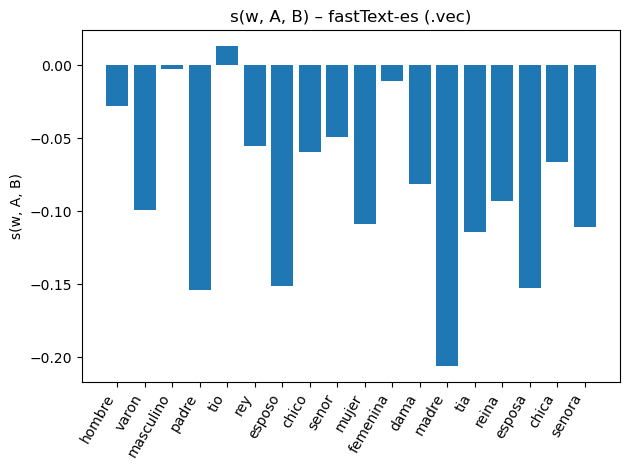

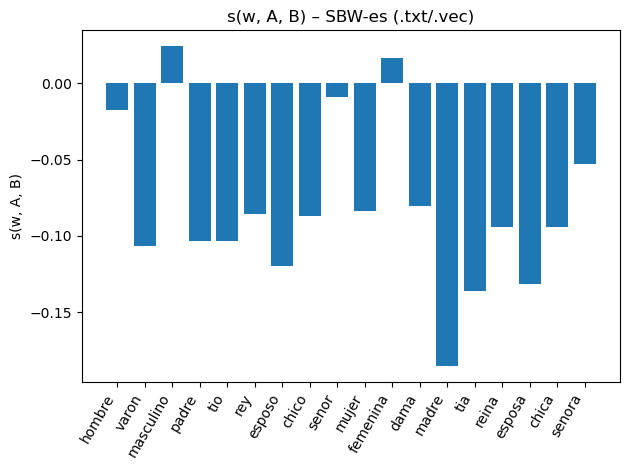

In [12]:
def s_values_by_word(kv: KeyedVectors, X: List[str], Y: List[str], A: List[str], B: List[str]) -> Dict[str, float]:
    return {w: s_w_A_B(w, kv, A, B) for w in X + Y if w in kv}

def plot_s_values(kv: KeyedVectors, model_name: str):
    vals = s_values_by_word(kv, X, Y, A, B)
    words, svals = list(vals.keys()), list(vals.values())
    plt.figure()
    plt.bar(range(len(words)), svals)
    plt.xticks(range(len(words)), words, rotation=60, ha='right')
    plt.title(f"s(w, A, B) – {model_name}")
    plt.ylabel("s(w, A, B)")
    plt.tight_layout()
    plt.show()

if fasttext_kv is not None:
    plot_s_values(fasttext_kv, "fastText-es (.vec)")
if sbw_kv is not None:
    plot_s_values(sbw_kv, "SBW-es (.txt/.vec)")